<h1>1st order Training (optimization) methods</h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import jax.numpy as jnp
import jax

Let us consider the following function
$$
f(x) = e^(-\frac{x}{10})sin(x)+\frac{1}{10}cos(\pi x)
$$
defined over the interval [0, 10].

In [2]:
f = lambda x: np.sin(x) * np.exp(-0.1 * x) + 0.1 * np.cos(np.pi * x)
a, b = 0, 10

Define a function get_training_data that returns a collection of N training samples, adding a noise sampled from a normal distribution with zero mean and standard deviation noise. The output should be a pair of numpy matrices x, y, of dimension N times 1.

In [3]:
def get_training_data(N, noise):
    np.random.seed(0) # For reproducibility
    x = np.linspace(a, b, N)[:, None]
    y = f(x) + noise * np.random.randn(N, 1)
    return x, y

Plot now the function f(x) in the considered interval, together with 100 training samples with noise magnitude equal to 0.05.

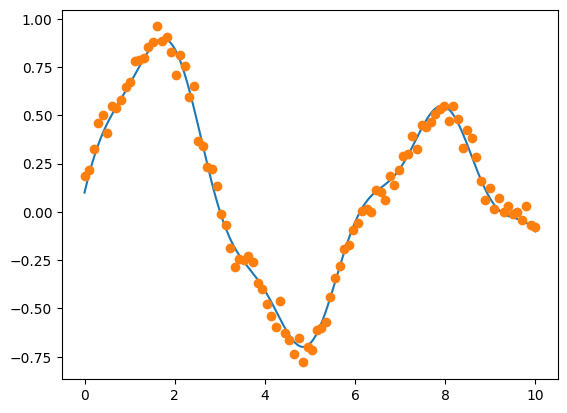

In [4]:
x_fine = np.linspace(a, b, 1000)[:, None]
plt.plot(x_fine, f(x_fine))

xx, yy = get_training_data(100, 0.05)
plt.plot(xx, yy, "o")

Write a function initialize_params that, given the input layers_size = [n1, n2, ..., nL], generates the parameters associated with an ANN, having as many layers as the number of elements of layers_size, with as many neurons as n1, n2, etc. <br>
Initialize weights sampling from a standard Gaussian distribution and biases with zero values.

In [5]:
def initialize_params(layers_size):
    np.random.seed(0) # For reproducibility
    params = list()
    for i in range(len(layers_size) - 1):
        W = np.random.randn(layers_size[i + 1], layers_size[i])
        b = np.zeros((layers_size[i + 1], 1))
        params.append(W)
        params.append(b)
    return params

Write a function ANN that implements an ANN, given the parameters params. Use tanh as activation function and do not apply the activation function to the last layer. <br>
By convention, both the input and the output have: <br>
- 1 sample per row
- 1 feature per column

In [6]:
def ANN(x, params):
    # layer = x.T
    layer = (2 * x.T - (a + b)) / (b - a)
    num_layers = int(len(params) / 2 + 1)
    weights = params[0::2]
    biases = params[1::2]
    for i in range(num_layers - 1):
        layer = jnp.dot(weights[i], layer) - biases[i]
        if i < num_layers - 2:
            layer = jnp.tanh(layer)
    return layer.T

Implement a function loss, that, given the input x, the target output y (i.e. the "labels") and the parameters params, returns the quadratic loss, defined as:
$$
L(x, y, \theta) = \frac{1}{m}\sum_{i=1}^{m}(y_i - ANN(x_i,\theta))^2
$$
where m is the number of samples in x, y and $\theta$ are the ANN parameters

In [7]:
def loss(x, y, params):
    error = ANN(x, params) - y
    return jnp.mean(error * error)

Test your code, by generating the parameters associated with ANN with two hidden layers with 5 neurons each and by computing the associated loss.

In [8]:
params = initialize_params([1, 5, 5, 1])
loss(xx, yy, params)

Array(0.28158015, dtype=float32)

The following cell provides an helper class that allows pnline plots during the training loop. Just run the cell, we will use it later.

In [9]:
from IPython import display

class Callback:
    def __init__(self, refresh_rate=250):
        self.refresh_rate = refresh_rate
        self.fig, self.axs = plt.subplots(1, 2, figsize=(16,8))
        self.x_fine = np.linspace(a, b, 200)[:, None]
        self.epoch = 0
        self.__call__(-1)

    def __call__(self, epoch):
        self.epoch = epoch
        if (epoch + 1) % self.refresh_rate == 0:
            self.draw()
            display.clear_output(wait=True)
            display.display(plt.gcf())
            time.sleep(1e-16)

    def draw(self):
        if self.epoch > 0:
            self.axs[0].clear()
            self.axs[0].loglog(history)
            self.axs[0].set_title("epoch %d" % (self.epoch + 1))

        self.axs[1].clear()
        self.axs[1].plot(self.x_fine, f(self.x_fine))
        self.axs[1].plot(self.x_fine, ANN(self.x_fine, params))
        self.axs[1].plot(xx, yy, "o")

<h2>Gradient Descent</h2>

Implement the GD method:
$$
\theta^{(0)}given \\
for k=0,1,...,n_{epochs}-1 \\
g^{(k)}=\frac{1}{N}\sum_{i=1}^{N}\nabla_{\theta}L(x_i, y_i, \theta^{(k)}) \\
\theta^{(k+1)} = \theta^{(k)} - \lambda g^{(k)}
$$
where N is the number of training samples. At each iteration, append the current cost to the list history. <br>
Hints: <br>
- Use jax.jit to speedup the evaluation of the loss and of the gradients.
- To us the visualization callback, just initialize it outside the training loop with:

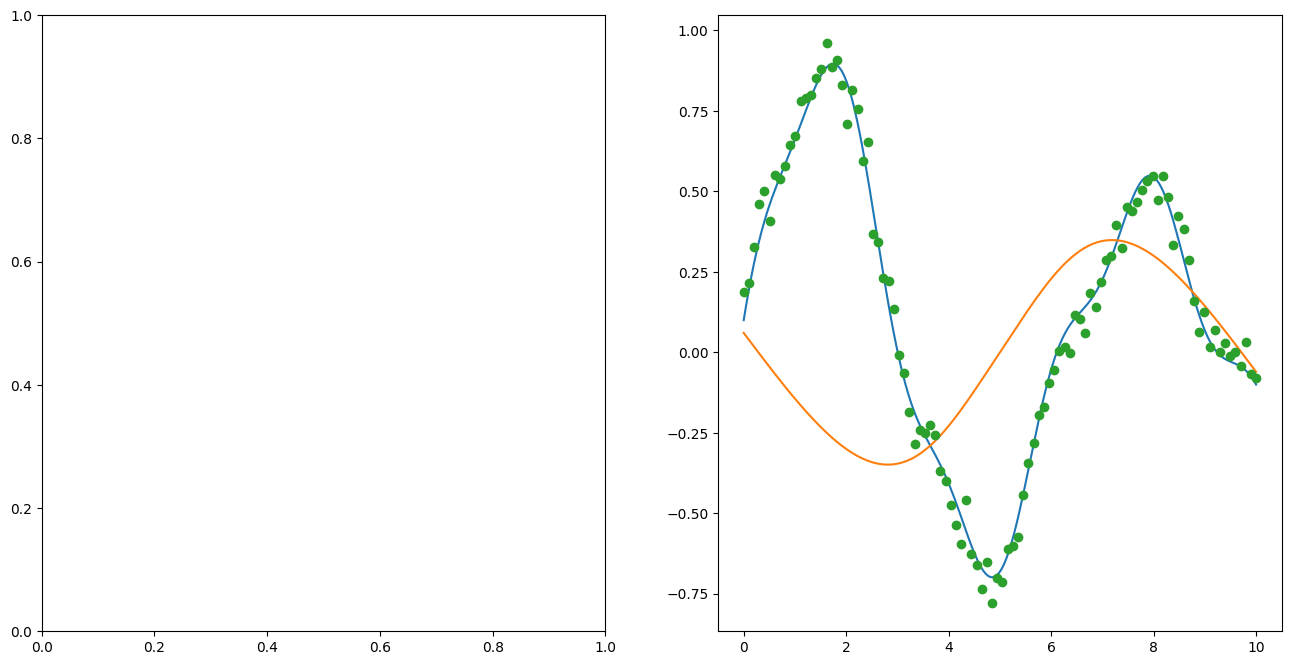

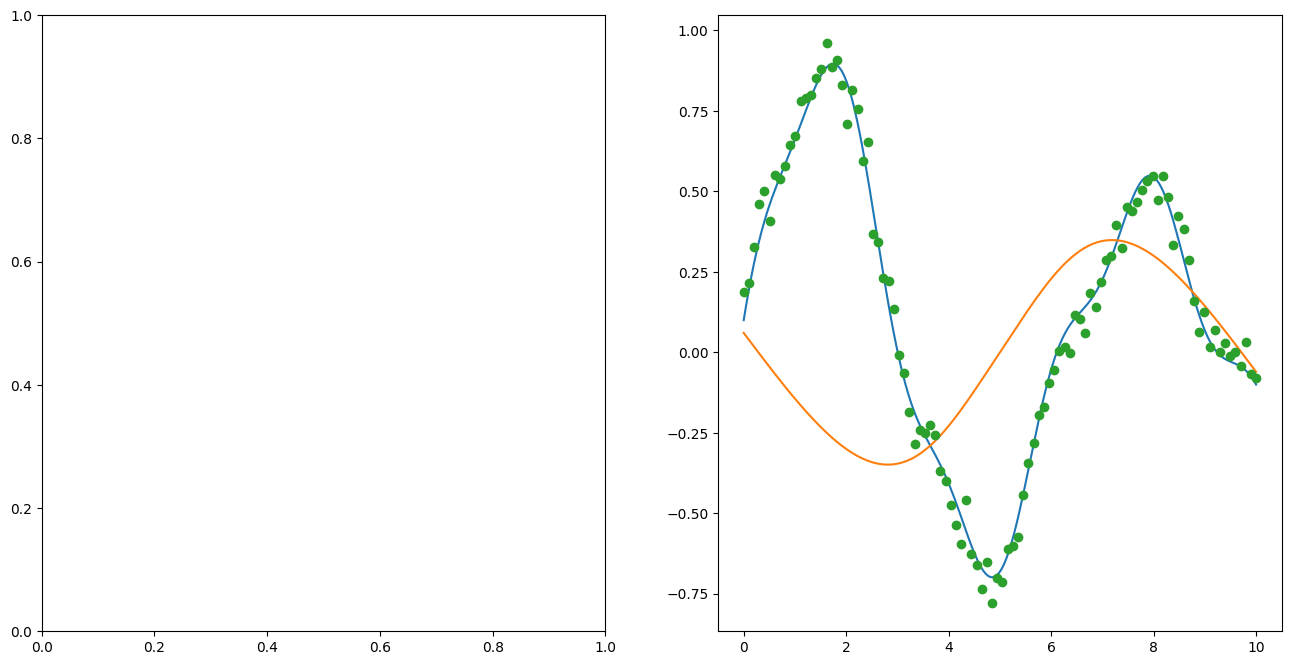

In [10]:
cb = Callback(refresh_rate=250)

and after each training epoch call cb(epoch), where epoch is the epoch index. Finally, call db.draw() when training is over. <br>
Test your code with: <br>
- 100 training points
- noise magnitude 0.05
- two hidden layers of 5 neurons each
- 2000 epochs <br>
Experiment different choices of learning rate $\lambda$, trying to maximize the performance of the algorithm. <br>
Does it look like your ANN is struggling to learn? Try to figure out why and figure out how to fix this issue.

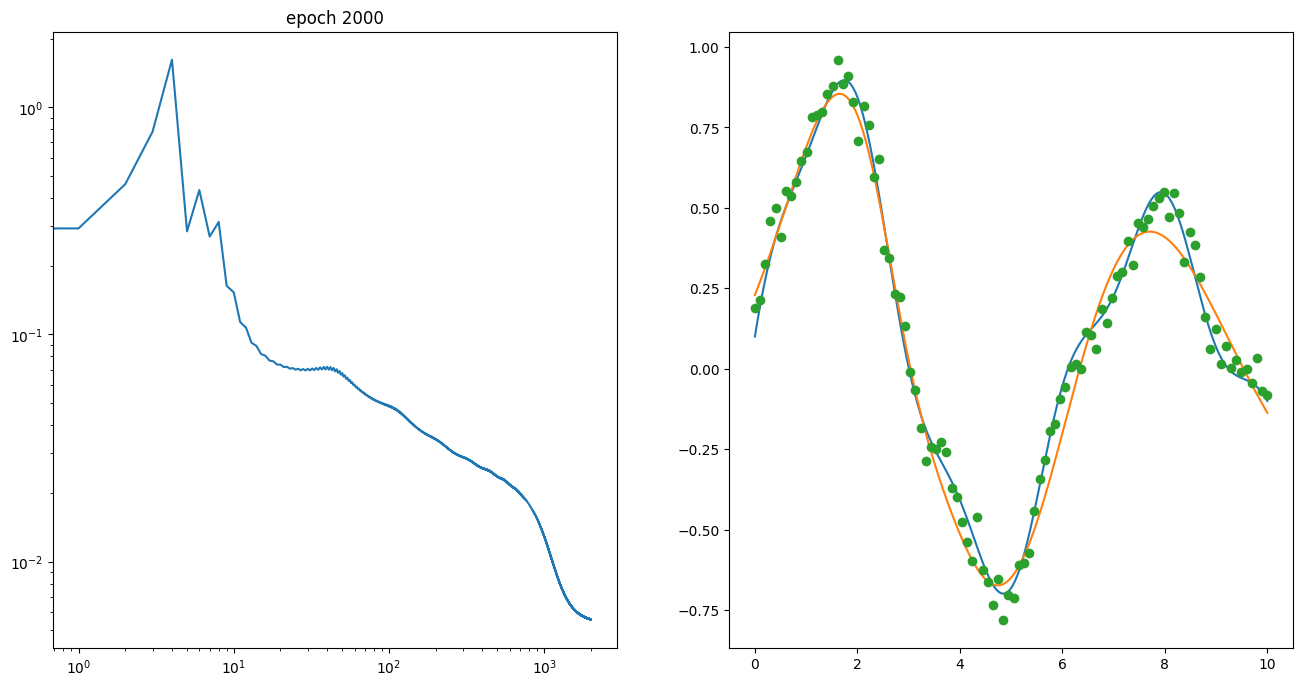

loss: 5.552e-03


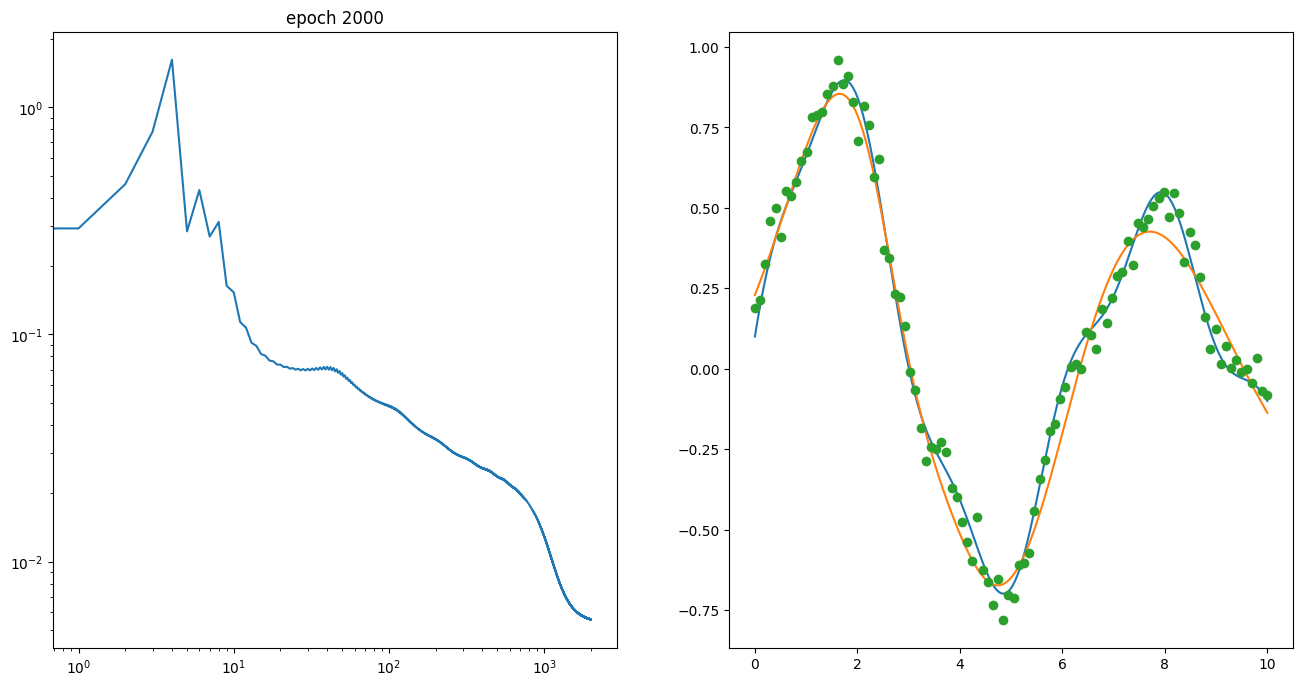

In [11]:
# Data
n_training_points = 100
noise = 0.05
# Hyperparameters
layers_size = [1, 5, 5, 1]
# Training options
num_epochs = 2000
learning_rate = 1e-1
############################################

xx, yy = get_training_data(n_training_points, noise)
params = initialize_params(layers_size)

loss_jit = jax.jit(loss)
grad_jit = jax.jit(jax.grad(loss, argnums=2))

history = list()
history.append(loss_jit(xx, yy, params))

cb = Callback(refresh_rate=200)

for epoch in range(num_epochs):
    grad = grad_jit(xx, yy, params)
    for i in range(len(params)):
        params[i] -= learning_rate * grad[i]
    history.append(loss_jit(xx, yy, params))
    cb(epoch)

cb.draw()

print("loss: %1.3e" % history[-1])

<h2>Stochastic Gradient Descent</h2>

Implement the SGD method:
$$
\theta^{(0)}given \\
for k=0,1,...,n_{epochs}-1 \\
g^{(k)}=\frac{1}{|I_k|}\sum_{i \in I_k}\nabla_{\theta}L(x_i, y_i, \theta^{(k)}) \\
\theta^{(k+1)} = \theta^{(k)} - \lambda_k g^{(k)}
$$
where $I_k$ is the current minibatch. To select it, use the function np.random.choice with replacement. <br>
Consider a linear decay of the learning rate:
$$
\lambda_k=max(\lambda_{min}, \lambda_{max}(1-\frac{k}{K}))
$$
Test different choices of batch size and try to optimize the learning rate decay strategy.

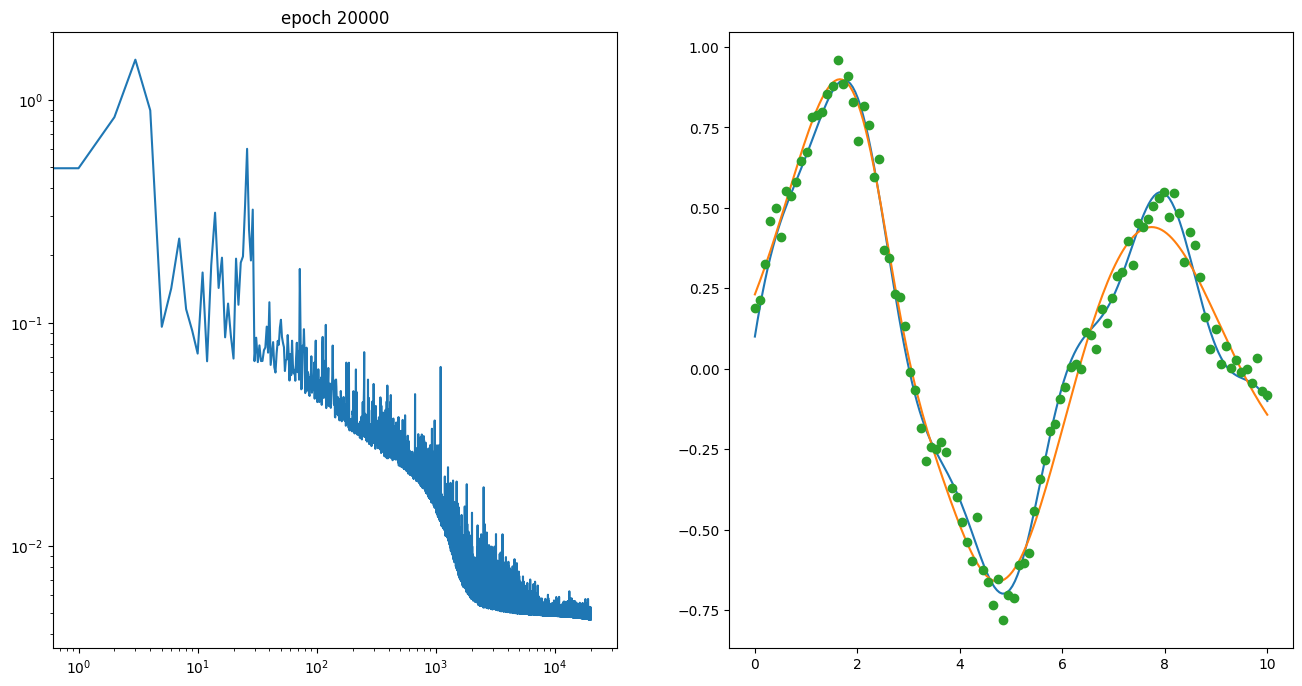

loss: 4.761e-03


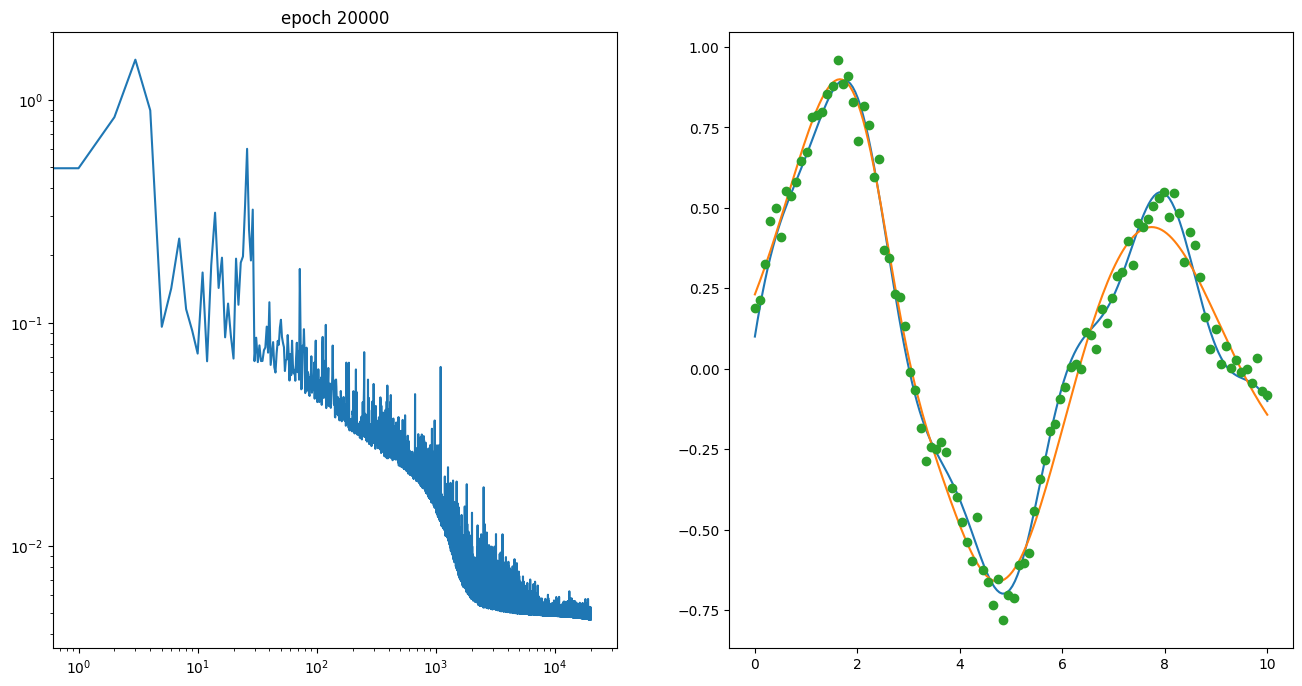

In [12]:
# Data
n_training_points = 100
noise = 0.05
# Hyperparameters
layers_size = [1, 5, 5, 1]
# Training options
num_epochs = 20000
learning_rate_max = 1e-1
learning_rate_min = 2e-2
learning_rate_decay = 10000
batch_size = 10
############################################

xx, yy, = get_training_data(n_training_points, noise)
params = initialize_params(layers_size)

loss_jit = jax.jit(loss)
grad_jit = jax.jit(jax.grad(loss, argnums=2))

history = list()
history.append(loss_jit(xx, yy, params))

cb = Callback(refresh_rate=250)

for epoch in range(num_epochs):
    learning_rate = max(
        learning_rate_min, learning_rate_max * (1 - epoch / learning_rate_decay)
    )
    idxs = np.random.choice(n_training_points, batch_size)
    grads = grad_jit(xx[idxs, :], yy[idxs, :], params)
    for i in range(len(params)):
        params[i] -= learning_rate * grads[i]

    history.append(loss_jit(xx, yy, params))
    cb(epoch)
cb.draw()

print("loss: %1.3e" % history[-1])

<h2>Stochastic Gradient Descent with momentum</h2>

Implement the SGD method with momentum:
$$
\theta^{(0)}given,v^{(0)}=0 \\
for k=0,1,...,n_{epochs}-1 \\
g^{(k)}=\frac{1}{|I_k|}\sum_{i\in{I_k}}\nabla_{\theta}L(x_i, y_i, \theta^{(k)}) \\
v^{(k+1)} = \alpha v^{(k)}-\lambda_k g^{(k)} \\
\theta^{(k+1)} = \theta^{(k)} - v^{(k+1)}
$$
Test different choices of $\alpha$.

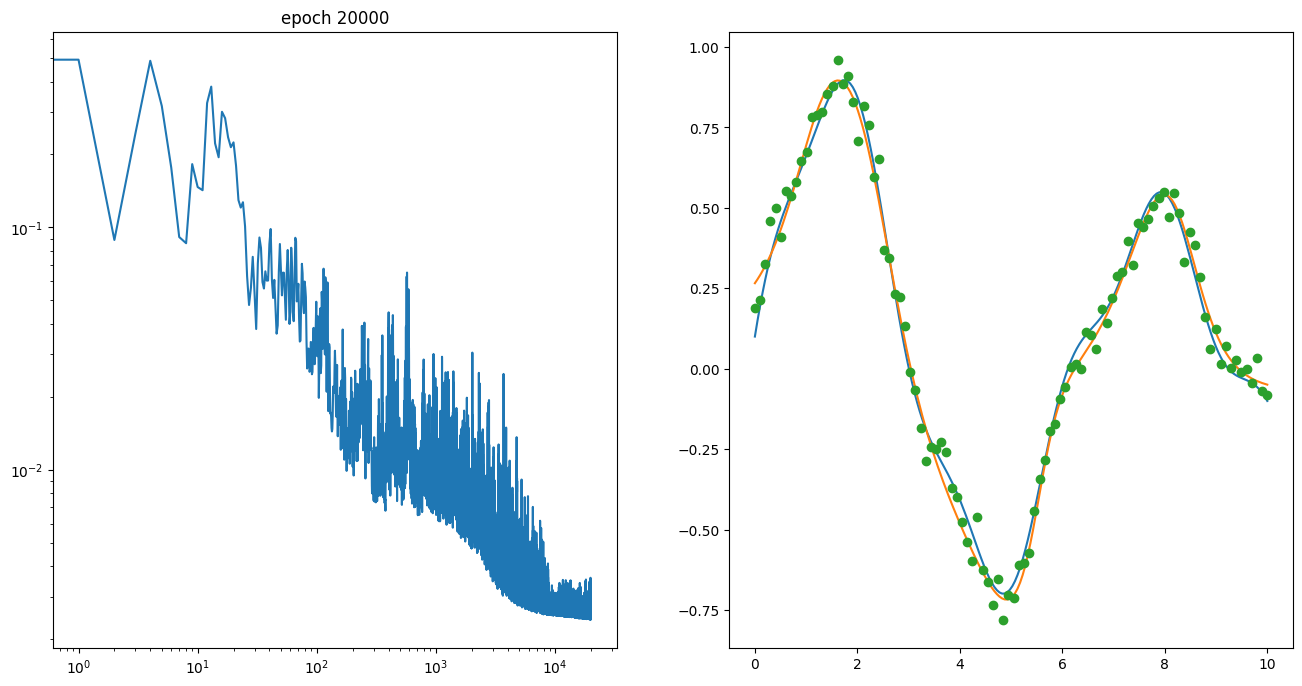

loss: 2.551e-03


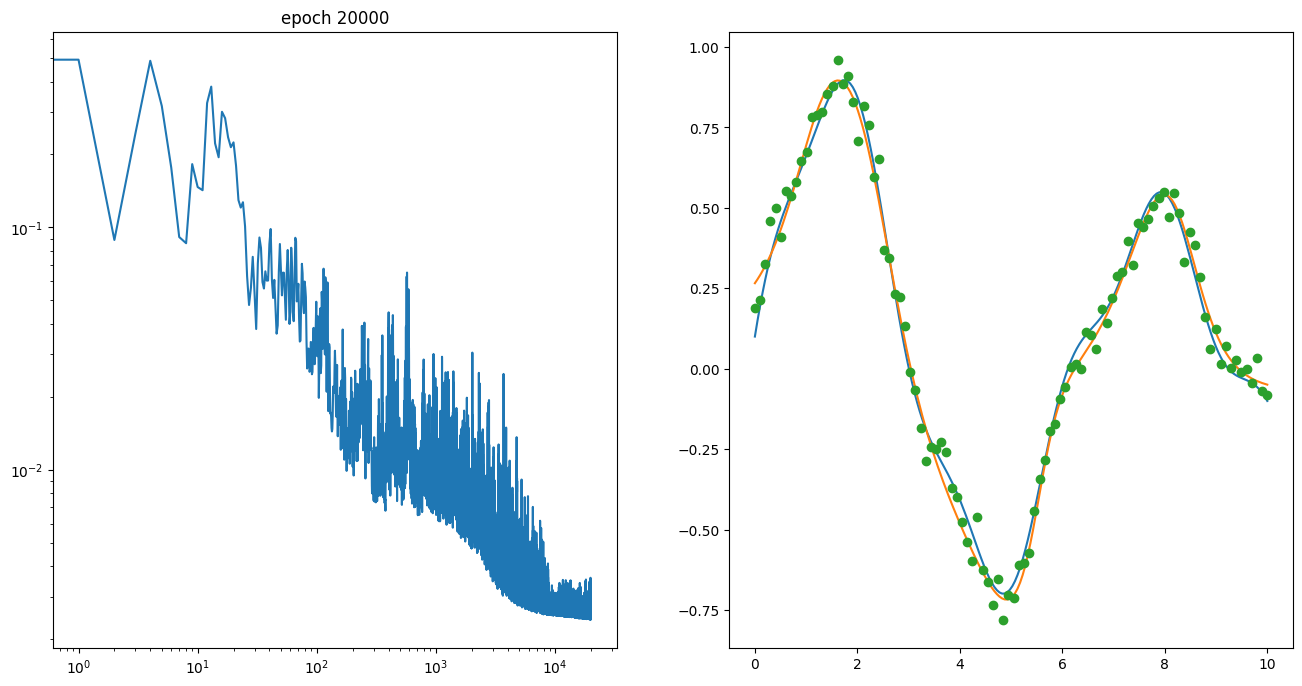

In [13]:
# Data
n_training_points = 100
noise = 0.05
# Hyperparameters
layers_size = [1, 5, 5, 1]
# Training options
num_epochs = 20000
learning_rate_max = 1e-1
learning_rate_min = 1e-2
alpha = 0.9
#####################################

xx, yy = get_training_data(n_training_points, noise)
params = initialize_params(layers_size)

loss_jit = jax.jit(loss)
grad_jit = jax.jit(jax.grad(loss, argnums=2))

history = list()
history.append(loss_jit(xx, yy, params))

cb = Callback(refresh_rate=250)

velocity = [0.0 for _ in range(len(params))]
for epoch in range(num_epochs):
    learning_rate = max(
        learning_rate_min, learning_rate_max * (1 - epoch / learning_rate_decay)
    )
    idxs = np.random.choice(n_training_points, batch_size)
    grads = grad_jit(xx[idxs, :], yy[idxs, :], params)

    for i in range(len(params)):
        velocity[i] = alpha * velocity[i] - learning_rate * grads[i]
        params[i] += velocity[i]

    history.append(loss_jit(xx, yy, params))
    cb(epoch)
cb.draw()

print("loss: %1.3e" % history[-1])

<h2>AdaGrad</h2>

Implement the AdaGrad algorithm:
$$
\theta^{(0)}given,r^{(0)}=0 \\
for k=0,1,...,n_{epochs}-1 \\
g^{(k)}=\frac{1}{|I_k|}\sum_{i\in{I_k}}\nabla_{\theta}L(x_i, y_i, \theta^{(k)}) \\
r^{(k+1)} = r^{(k)} + g^{(k)} \odot g^{(k)} \\
\theta^{(k+1)} = \theta^{(k)} - \frac{\lambda}{\delta + \sqrt{r^{(k+1)}}} \odot g^{(k)}
$$
where $\delta=10^{-7}$ is a small constant. Notice that the operations in the last line should be interpreted "componentwise". Test different choices of the learning rate $\lambda$.

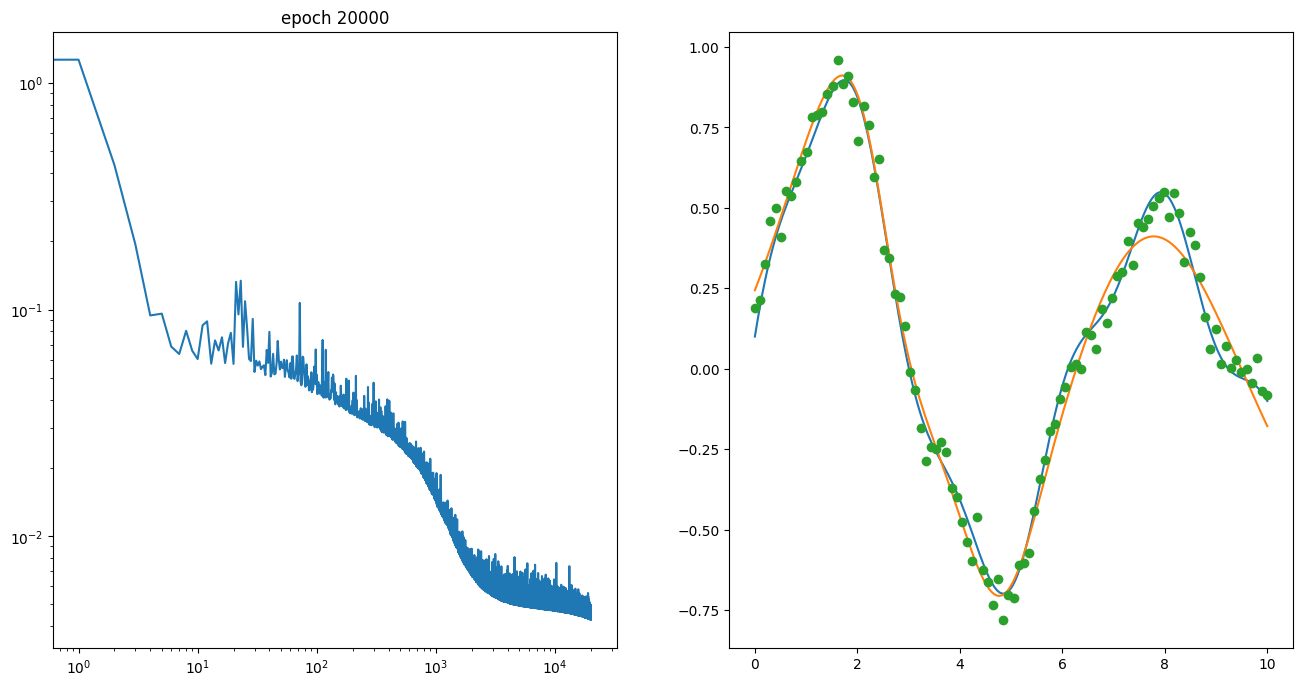

loss: 4.458e-03


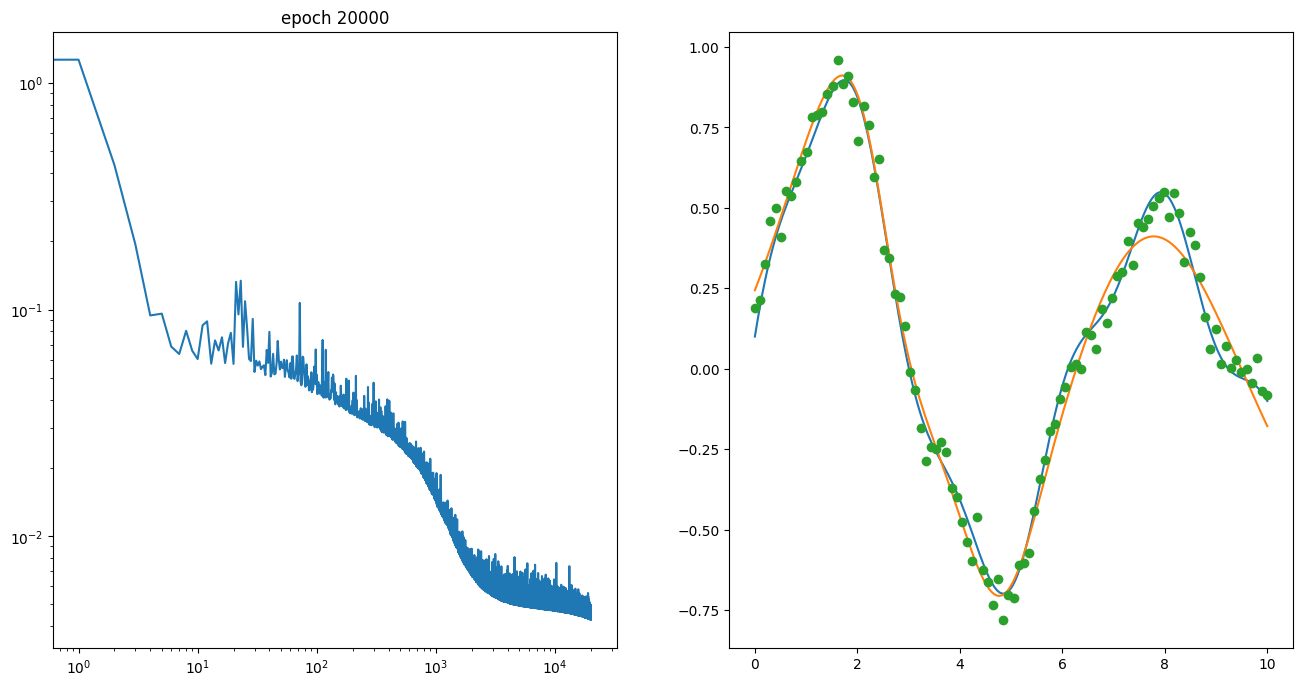

In [14]:
# Data
n_training_points = 100
noise = 0.05
# Hyperparameters
layers_size = [1, 5, 5, 1]
# Training options
num_epochs = 20000
batch_size = 10
learning_rate = 1e-1
delta = 1e-7
#####################################

xx, yy = get_training_data(n_training_points, noise)
params = initialize_params(layers_size)

loss_jit = jax.jit(loss)
grad_jit = jax.jit(jax.grad(loss, argnums=2))

history = list()
history.append(loss_jit(xx, yy, params))

cb = Callback(refresh_rate=250)

cumulated_square_grad = [0.0 for _ in range(len(params))]
for epoch in range(num_epochs):
    idxs = np.random.choice(n_training_points, batch_size)
    grads = grad_jit(xx[idxs, :], yy[idxs, :], params)

    for i in range(len(params)):
        cumulated_square_grad[i] += grads[i] * grads[i]
        params[i] -= grads[i] * learning_rate / (delta + jnp.sqrt(cumulated_square_grad[i]))

    history.append(loss_jit(xx, yy, params))
    cb(epoch)
cb.draw()

print("loss: %1.3e" % history[-1])

<h2>RMSProp</h2>

Implement the RMSProp algorithm:
$$
\theta^{(0)}given,r^{(0)}=0 \\
for k=0,1,...,n_{epochs}-1 \\
g^{(k)}=\frac{1}{|I_k|}\sum_{i\in{I_k}}\nabla_{\theta}L(x_i, y_i, \theta^{(k)}) \\
r^{(k+1)} = \rho r^{(k)} + (1-\rho)g^{(k)} \odot g^{(k)} \\
\theta^{(k+1)} = \theta^{(k)} - \frac{\lambda}{\delta + \sqrt{r^{(k+1)}}} \odot g^{(k)}
$$
Where $\delta=10^{-7}$ is a small constant. Test different choices of the learning rate $\lambda$ and decay rate $\rho$.

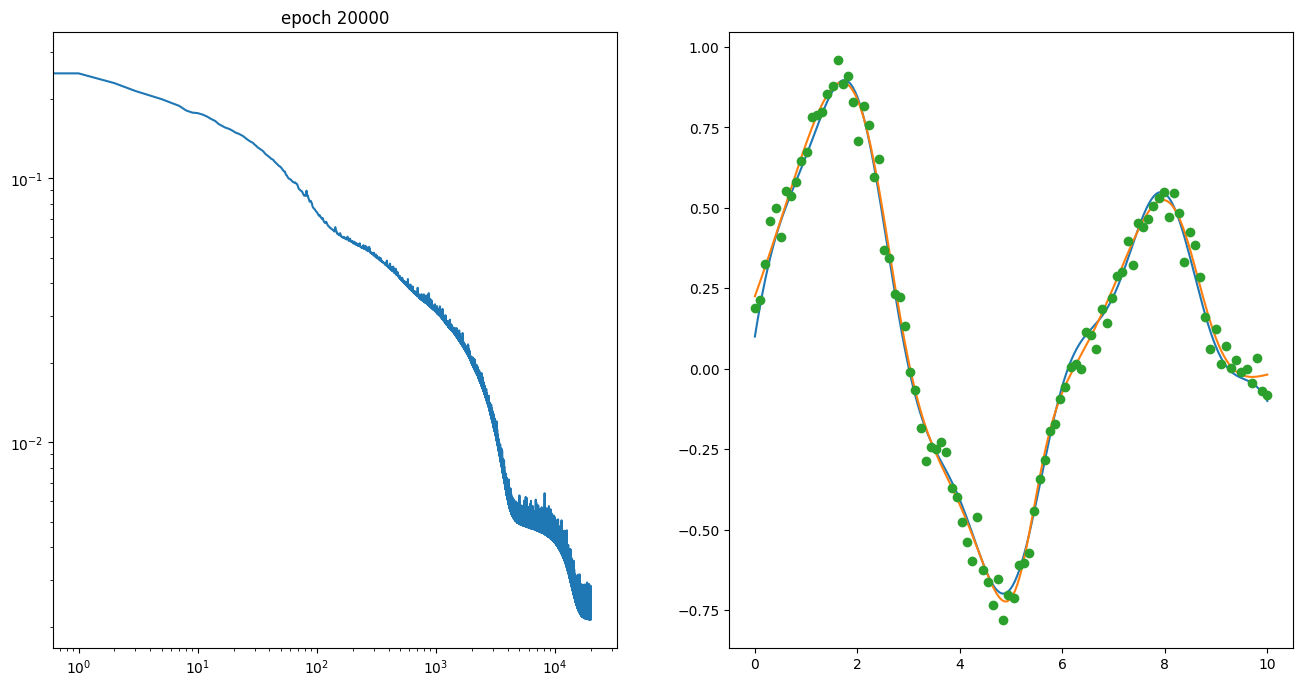

loss: 2.169e-03


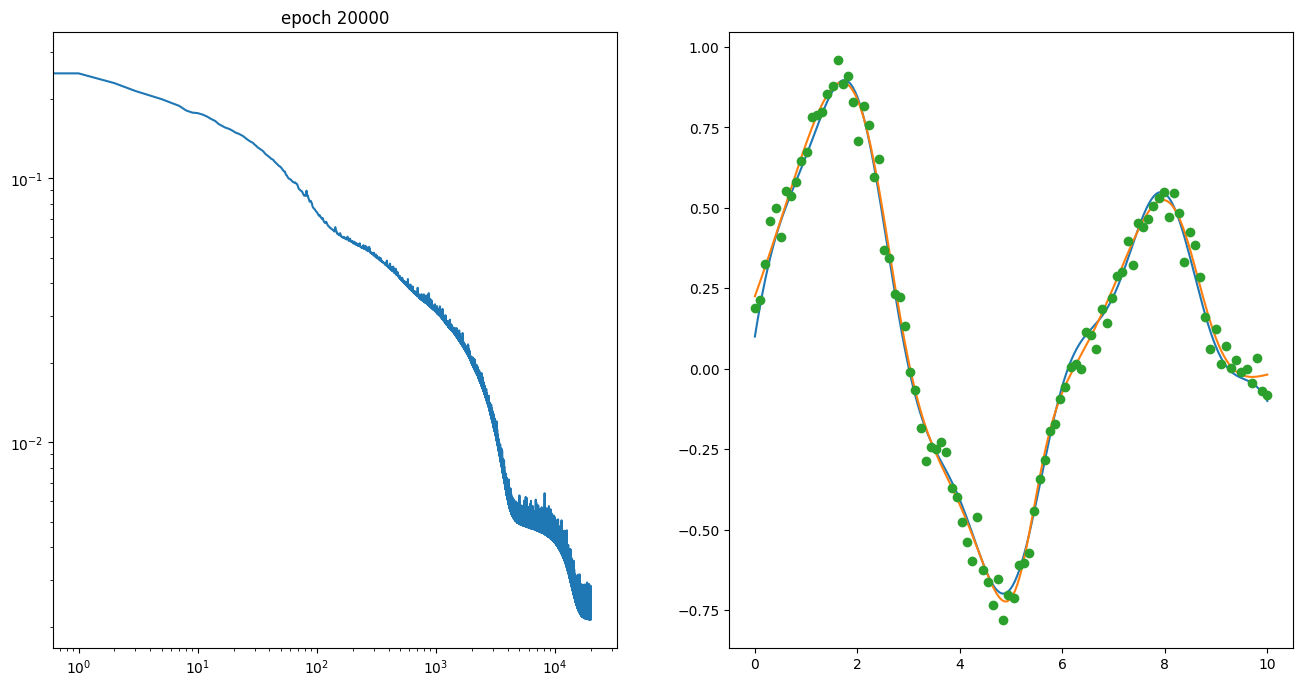

In [15]:
# Data
n_training_points = 100
noise = 0.05
# Hyperparameters
layers_size = [1, 5, 5, 1]
# Training options
num_epochs = 20000
batch_size = 50
learning_rate = 1e-3
decay_rate = 0.9
delta = 1e-7
#####################################

xx, yy = get_training_data(n_training_points, noise)
params = initialize_params(layers_size)

loss_jit = jax.jit(loss)
grad_jit = jax.jit(jax.grad(loss, argnums=2))

history = list()
history.append(loss_jit(xx, yy, params))

cb = Callback(refresh_rate=250)

cumulated_square_grad = [0.0 for _ in range(len(params))]
for epoch in range(num_epochs):
    idxs = np.random.choice(n_training_points, batch_size)
    grads = grad_jit(xx[idxs, :], yy[idxs, :], params)

    for i in range(len(params)):
        cumulated_square_grad[i] = decay_rate * cumulated_square_grad[i] + (1 - decay_rate) * grads[i] * grads[i]
        params[i] -= grads[i] * learning_rate / (delta + jnp.sqrt(cumulated_square_grad[i]))

    history.append(loss_jit(xx, yy, params))
    cb(epoch)
cb.draw()

print("loss: %1.3e" % history[-1])

<h1>Newton method</h1>

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import time
import jax.numpy as jnp
import jax
import time

# We enable double precision in JAX
jax.config.update("jax_enable_x64", True)

We consider a random matrix $A \in \mathbb{R}^{n \times n}$, with n=100 and a random vector $x_{ex} \in \mathbb{R}^n$. We define then $b=Ax_{ex}$.

In [17]:
n = 100

np.random.seed(0)
A = np.random.randn(n, n)
x_ex = np.random.randn(n)
b = A @ x_ex

Define the loss function
$$
L(x) = ||b-Ax||^2_2
$$

In [18]:
def loss(x):
    return jnp.sum(jnp.square(A @ x - b))

print(loss(x_ex))

0.0


By using the jax library, implement and compile functions returning the gradient $(\nabla L(x))$ and the Hessian $(\nabla^2 L(x))$ of the loss function. <br>

In [19]:
grad = jax.grad(loss)
hess = jax.jacfwd(jax.jacrev(loss))

loss_jit = jax.jit(loss)
grad_jit = jax.jit(grad)
hess_jit = jax.jit(hess)

Check that the results are correct (up to machine precision).

In [20]:
np.random.seed(0)
x_guess = np.random.randn(n)

G_ad = grad_jit(x_guess)
G_ex = 2 * A.T @ (A @ x_guess - b)
print(np.linalg.norm(G_ad - G_ex))

H_ad = hess_jit(x_guess)
H_ex = 2 * A.T @ A
print(np.linalg.norm(H_ad - H_ex))

9.707921159164663e-13
0.0


Exploit the formula
$$
\nabla^2 L(x)v = \nabla_x \phi(x,v)
$$
where
$$
\phi(x,v) = \nabla L(x) \cdot v
$$
to write an optimized function returning the hessian-vector product
$$
(x, v) \rightarrow \nabla^2 L(x)v.
$$
Compare the computational performance w.r.t. the full hessian computation.

In [21]:
np.random.seed(1)
v = np.random.randn(n)

hvp_basic = lambda x, v: hess(x) @ v
gvp = lambda x, v: jnp.dot(grad(x), v)
hvp = lambda x, v: jax.grad(gvp, argnums=0)(x, v)

hvp_basic_jit = jax.jit(hvp_basic)
hvp_jit = jax.jit(hvp)

Hv_ad = hvp_jit(x_guess, v)
Hv_ex = H_ex @ v
print(np.linalg.norm(Hv_ad - Hv_ex))

1.5923499043932032e-12


In [22]:
%timeit hvp_basic_jit(x_guess, v)
%timeit hvp_jit(x_guess, v)

74.8 μs ± 2.18 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
11.9 μs ± 25.7 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Implement the Newton method for the minimization of the loss function L. Set a maximum number of 100 iterations and a tolerance on the increment norm of $\epsilon=10^{-8}$.

In [23]:
x = x_guess.copy()
num_epochs = 100
eps = 1e-8

elapsed_time = 0

for epoch in range(num_epochs):
    t0 = time.time()
    G = grad_jit(x)
    H = hess_jit(x)
    incr = np.linalg.solve(H, -G)
    elapsed_time += time.time() - t0
    x += incr

    print("============ epoch %d" % epoch)
    print("loss: %1.3e" % loss_jit(x))
    print("grad: %1.3e" % np.linalg.norm(G))
    print("incr: %1.3e" % np.linalg.norm(incr))

    if np.linalg.norm(incr) < eps:
        break

print(f"Elapsed time: {elapsed_time:.4f} [s]")
rel_err = np.linalg.norm(x - x_ex) / np.linalg.norm(x_ex)
print(f"Relative error: {rel_err:1.3e}")

============ epoch 0
loss: 8.335e-23
grad: 6.026e+03
incr: 1.548e+01
============ epoch 1
loss: 7.787e-28
grad: 3.771e-12
incr: 9.077e-10
Elapsed time: 0.0082 [s]
Relative error: 2.585e-14


In [24]:
def conjugate_gradient(matvec_fn, b, tol=1e-12, max_iter=1000):
    """
    Conjugate Gradient Solver for Ax = b, where A is only accessible via matvec_fn
    """
    x = jnp.zeros_like(b)
    r = b - matvec_fn(x) # Residual
    p = r
    rsold = jnp.dot(r, r)

    for _ in range(max_iter):
        Ap = matvec_fn(p)
        alpha = rsold / jnp.dot(p, Ap)
        x = x + alpha * p
        r = r - alpha * Ap
        rsnew = jnp.dot(r, r)
        if jnp.sqrt(rsnew) < tol:
            break
        p = r + (rsnew /rsold) * p
        rsold = rsnew
        return x
    
x = x_guess.copy()
num_epochs = 100
eps = 1e-8

elapsed_time = 0

for epoch in range(num_epochs):
    t0 = time.time()
    G = grad_jit(x)
    # lambda v: hess_jit(x) @ v
    incr = conjugate_gradient(lambda v: hvp_jit(x, v), -G, tol=1e-15, max_iter=1000)
    elapsed_time += time.time() - t0
    x += incr

    print("============ epoch %d" % epoch)
    print("loss: %1.3e" % loss_jit(x))
    print("grad: %1.3e" % np.linalg.norm(G))
    print("incr: %1.3e" % np.linalg.norm(incr))

    if np.linalg.norm(incr) < eps:
        break

print(f"Elapsed time: {elapsed_time:.4f} [s]")
rel_err = np.linalg.norm(x - x_ex) / np.linalg.norm(x_ex)
print(f"Relative error: {rel_err:1.3e}")

============ epoch 0
loss: 4.950e+03
grad: 6.026e+03
incr: 1.077e+01
============ epoch 1
loss: 1.753e+03
grad: 1.730e+03
incr: 3.696e+00
============ epoch 2
loss: 9.283e+02
grad: 8.836e+02
incr: 1.868e+00
============ epoch 3
loss: 5.875e+02
grad: 5.343e+02
incr: 1.276e+00
============ epoch 4
loss: 4.114e+02
grad: 3.939e+02
incr: 8.939e-01
============ epoch 5
loss: 3.059e+02
grad: 2.900e+02
incr: 7.280e-01
============ epoch 6
loss: 2.371e+02
grad: 2.424e+02
incr: 5.674e-01
============ epoch 7
loss: 1.895e+02
grad: 1.925e+02
incr: 4.941e-01
============ epoch 8
loss: 1.554e+02
grad: 1.695e+02
incr: 4.027e-01
============ epoch 9
loss: 1.302e+02
grad: 1.394e+02
incr: 3.626e-01
============ epoch 10
loss: 1.110e+02
grad: 1.263e+02
incr: 3.035e-01
============ epoch 11
loss: 9.609e+01
grad: 1.064e+02
incr: 2.800e-01
============ epoch 12
loss: 8.427e+01
grad: 9.873e+01
incr: 2.394e-01
============ epoch 13
loss: 7.470e+01
grad: 8.488e+01
incr: 2.254e-01
============ epoch 14
loss: 6.

Repeat the optimization loop for the loss function
$$
L(x) = ||b-Ax||^4_4
$$

In [25]:
def loss(x):
    return jnp.sum((A @ x - b) ** 4)

grad = jax.grad(loss)
hess = jax.jacfwd(jax.jacrev(loss))

loss_jit = jax.jit(loss)
grad_jit = jax.jit(grad)
hess_jit = jax.jit(hess)

convergence reached!
epochs: 50
relative error: 1.657e-09


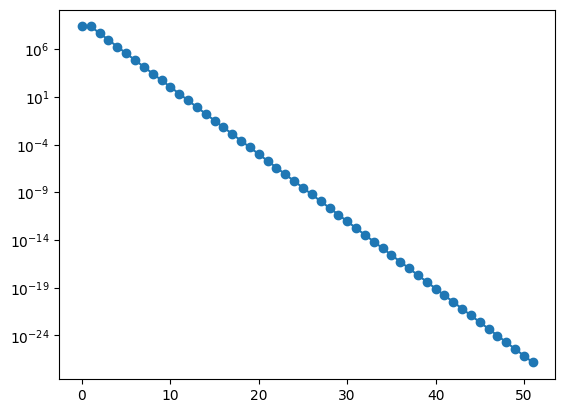

In [26]:
x = x_guess.copy()
num_epochs = 100
eps = 1e-8

hist = [loss_jit(x)]
t0 = time.time()
for epoch in range(num_epochs):
    l = loss_jit(x)
    hist.append(l)
    H = hess_jit(x)
    G = grad_jit(x)
    incr = np.linalg.solve(H, -G)
    x += incr
    if np.linalg.norm(incr) < eps:
        print("convergence reached!")
        break

ttot = time.time() - t0

plt.semilogy(hist, "o-")
print("epochs: %d" % epoch)
print("relative error: %1.3e" % (np.linalg.norm(x - x_ex) / np.linalg.norm(x_ex)))

<h2>Quasi-Newton Optimization with BFGS Update</h2>

This algorithm minimizes an objective function f(x) using a quasi-Newton method with the BFGS Update. The goal is to iteratively update the solution x and approximate the inverse Hessian until convergence criteria are met. <br><br>
Algorithm <br>
1. Initialization:
    - Set the initial guess $x=x_{guess}$.
    - Let I be the identity matrix, and initialize $B^{-1}$=I.
    - Compute the initial gradient $\nabla f=\nabla f(x_{guess})$.
    - Initialize the loss history: $history=|f(x_{guess})|$.
    - Set $epoch=0$.
$$
B^{-1}=I, \nabla f=\nabla f(x_{guess}), history=|f(x_{guess})|
$$
2. Iterative Updates:
    - While $||\nabla f|| > tol$ and $epoch < max\_epochs$
        - Increment the epoch counter: $$ epoch = epoch + 1 $$
        - Compute the search direction: $$ p=-B^{-1}\nabla f $$
        - Perform a line search to find the step size $\alpha$ using sp.optimize.line_search: $$ \alpha = line\_search(f, \nabla f, x, p).$$ If $\alpha$ is not found, set $\alpha=10^{-8} $
        - Update the solution vector: $$ x_{new}=x+\alpha p $$
        - Compute the displacement: $$ s=x_{new}-x $$
        - Update x: $$ x=x_{new} $$
        - Compute the new gradient and gradient difference: $$ \nabla f_{new}=\nabla f(x), y=\nabla f_{new}-\nabla f $$ Update $\nabla f$: $$ \nabla f=\nabla f_{new} $$
        - Compute the scalar $\rho$: $$ \rho = \frac{1}{y^Ts} $$
        - Update the inverse Hessian approximation $B^{-1}$ using the Sherman-Morrison formula: $$ E = I- \rho y s^T \\ B^{-1} = E^T B^{-1}E+\rho ss^T $$
        - Append the current loss value to history: $$history.append(f(x))$$

/var/folders/bp/hmznzd1s4z7_6knw0r1lrmmh0000gn/T/ipykernel_76721/2119888453.py:20: LineSearchWarning: The line search algorithm did not converge
  alpha = sp.optimize.line_search(loss_jit, grad_jit, x, p)[0]


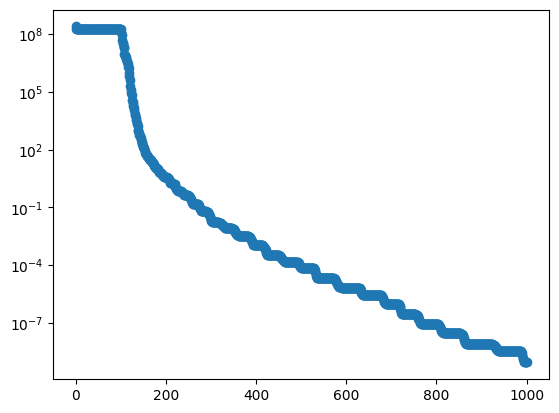

In [30]:
max_epochs = 1000
tol = 1e-8

import scipy as sp

np.random.seed(0)

epoch = 0
x = x_guess.copy()
I = np.eye(x.size)
Binv = I
grad = grad_jit(x)
history = [loss_jit(x)]

while np.linalg.norm(grad) > tol and epoch < max_epochs:
    epoch += 1
    p = -Binv @ grad

    # Line search
    alpha = sp.optimize.line_search(loss_jit, grad_jit, x, p)[0]
    if alpha is None:
        alpha = 1e-8
    
    x_new = x + alpha * p

    s = x_new - x
    x = x_new
    grad_new = grad_jit(x_new)
    y = grad_new - grad
    grad = grad_new

    rho = 1.0 / np.dot(y, s)
    E = I - rho * np.outer(y, s)
    Binv = E.T @ Binv @ E + rho * np.outer(s, s)

    history.append(loss_jit(x))

plt.semilogy(history, "o-")

<h1>Regularization of ANN weights<h1>

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
import jax.numpy as jnp
import jax

Load the Auto MPG dataset.

In [33]:
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
column_names = [
    "MPG",
    "Cylinders",
    "Displacement",
    "Horsepower",
    "Weight",
    "Acceleration",
    "Model Year",
    "Origin"
]
data = pd.read_csv(
    url, sep=" ", names=column_names, na_values="?", comment="\t", skipinitialspace=True
)
data

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1


Check if there are missing entries in the dataset.

In [34]:
print(data.isna().sum())

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


Remove records with missing entries.

In [35]:
data = data.dropna()
print(data.isna().sum())

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


<h3>Data inspection</h3>
Display some basic information.

In [36]:
data.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           392 non-null    float64
 1   Cylinders     392 non-null    int64  
 2   Displacement  392 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        392 non-null    float64
 5   Acceleration  392 non-null    float64
 6   Model Year    392 non-null    int64  
 7   Origin        392 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 27.6 KB


In [39]:
data.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


We are interested in predicting the field MPG, measuring fuel efficiency, expressed in miles per gallon (MPG), where 1 MPG = 0.354006 km/L. Plot its distribution.

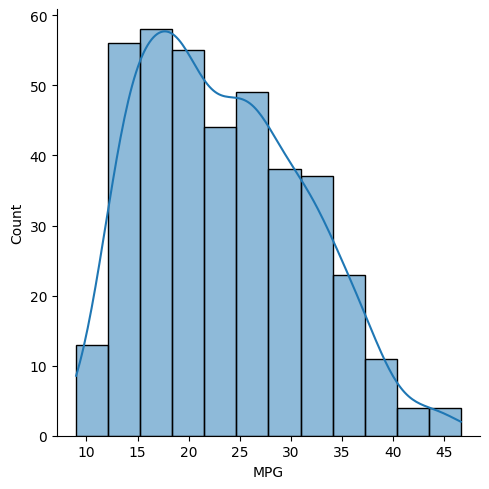

In [40]:
sns.displot(data["MPG"], kde=True)

Look for linear correlations among data

In [41]:
data.corr()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
MPG,1.000000,-0.777618,-0.805127,-0.778427,-0.832244,0.423329,0.580541,0.565209
Cylinders,-0.777618,1.000000,0.950823,0.842983,0.897527,-0.504683,-0.345647,-0.568932
Displacement,-0.805127,0.950823,1.000000,0.897257,0.932994,-0.543800,-0.369855,-0.614535
Horsepower,-0.778427,0.842983,0.897257,1.000000,0.864538,-0.689196,-0.416361,-0.455171
Weight,-0.832244,0.897527,0.932994,0.864538,1.000000,-0.416839,-0.309120,-0.585005
Acceleration,0.423329,-0.504683,-0.543800,-0.689196,-0.416839,1.000000,0.290316,0.212746
Model Year,0.580541,-0.345647,-0.369855,-0.416361,-0.309120,0.290316,1.000000,0.181528
Origin,0.565209,-0.568932,-0.614535,-0.455171,-0.585005,0.212746,0.181528,1.000000


<Axes: >

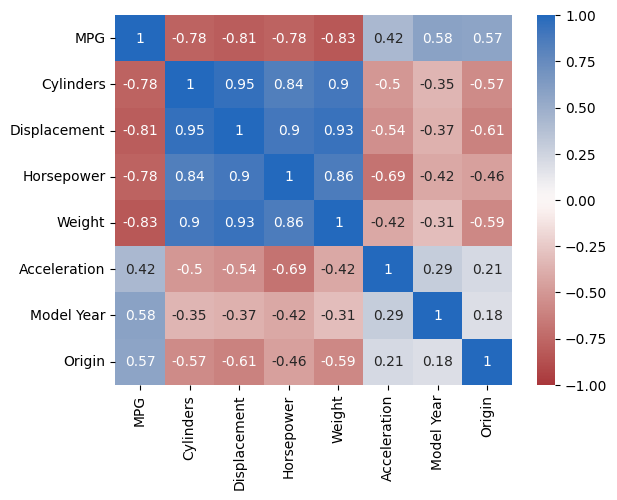

In [42]:
sns.heatmap(data.corr(), annot=True, cmap="vlag_r", vmin=-1, vmax=1)

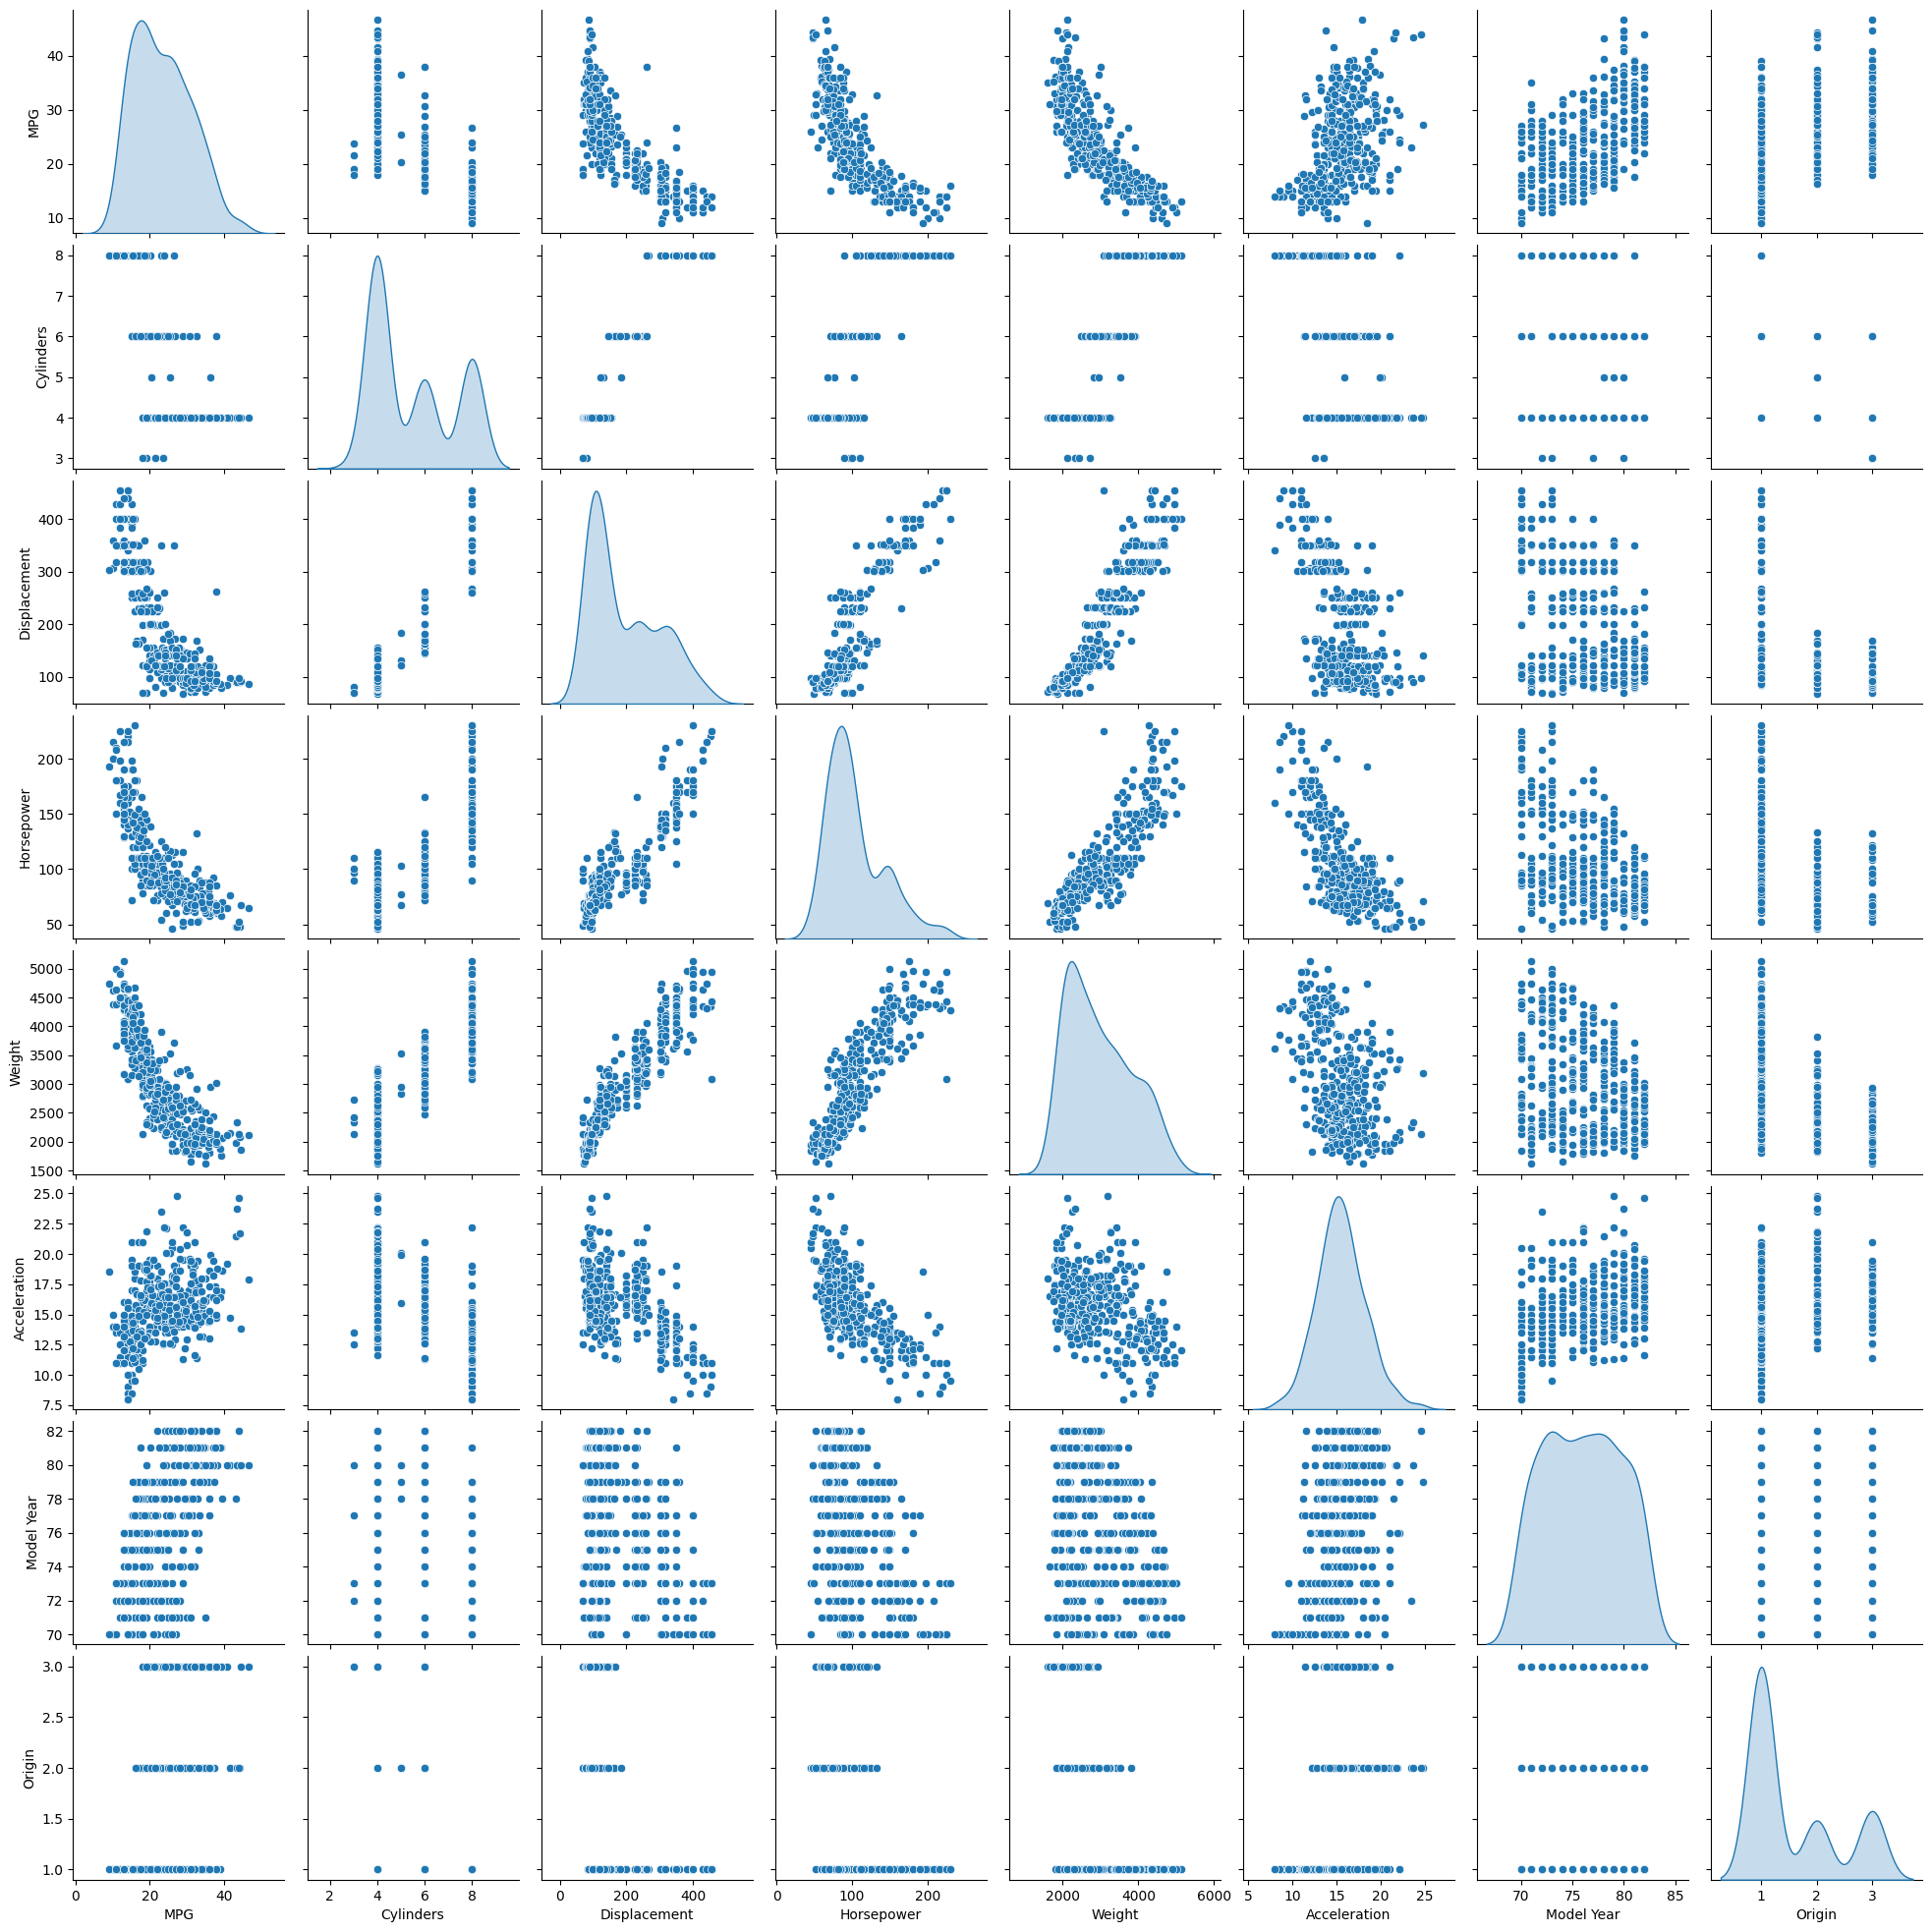

In [43]:
sns.pairplot(data, diag_kind="kde")

Apply an affine transformation to the data, so that each feature has zero mean and unitary standard deviation.

In [44]:
data_mean = data.mean()
data_std = data.std()
data_normalized = (data - data_mean) / data_std

<Axes: >

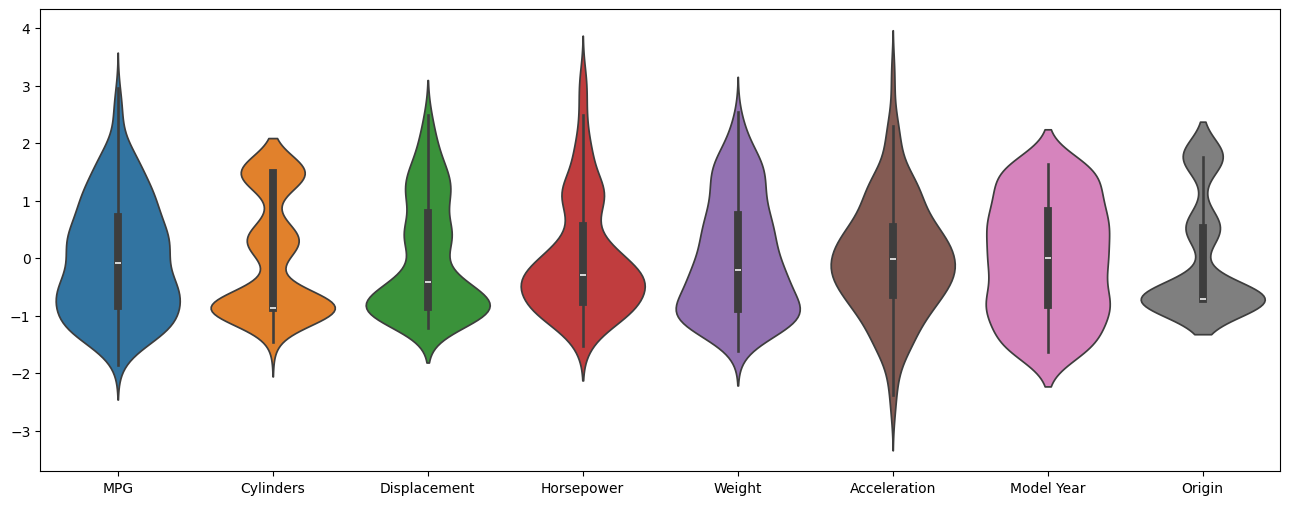

In [45]:
_, ax = plt.subplots(figsize=(16, 6))
sns.violinplot(data=data_normalized, ax=ax)

<h2>Train-validation split</h2>

Shuffle the data using the np.random.shuffle function and split the data as follows:
- put 80% in the train dataset
- put 20% in the validation dataset

In [47]:
data_normalized_np = data_normalized.to_numpy()
np.random.seed(0)
np.random.shuffle(data_normalized_np)

fraction_validation = 0.2
num_train = int(data_normalized_np.shape[0] * (1 - fraction_validation))
x_train = data_normalized_np[:num_train, 1:]
y_train = data_normalized_np[:num_train, :1]
x_valid = data_normalized_np[num_train:, 1:]
y_valid = data_normalized_np[num_train:, :1]

print("train set size: %d" % x_train.shape[0])
print("validation set size: %d" % x_valid.shape[0])

train set size: 313
validation set size: 79


<h2>ANN setup</h2>

Write a function params = initialize_params(layers_size) that initializes the parameters, given the ANN architecture. Initialize biases with zero values, and weights with a Glorot Normal initialization, i.e. sampling from a Gaussian distribution with zero mean and with standard deviation
$$
\sqrt{\frac{2}{n+m}},
$$
where n and m are the number of input and output neurons of the corresponding weights matrix.

In [48]:
def initialize_params(layers_size):
    np.random.seed(0) # For reproducibility
    params = list()
    for i in range(len(layers_size) - 1):
        W = np.random.randn(layers_size[i + 1], layers_size[i]) * np.sqrt(
            2 / (layers_size[i + 1] + layers_size[i])
        )
        b = np.zeros((layers_size[i + 1], 1))
        params.append(W)
        params.append(b)
    return params

Implement a generic feedforward ANN with a function y = ANN(x, params), using $ReLU$ as activation function.

In [50]:
activation = jax.nn.relu

def ANN(x, params):
    layer = x.T
    num_layers = int(len(params) / 2 + 1)
    weights = params[0::2]
    biases = params[1::2]
    for i in range(num_layers - 1):
        layer = weights[i] @ layer + biases[i]
        if i < num_layers - 2:
            layer = activation(layer)
    return layer.T

params = initialize_params([7, 10, 1])
ANN(x_train[:10, :], params)

Array([[-0.27655404],
       [-0.15536339],
       [ 0.48314802],
       [-0.56939886],
       [-0.00754281],
       [ 0.01332849],
       [ 0.02310115],
       [ 0.27127818],
       [ 0.35476032],
       [ 0.08180778]], dtype=float64)

Implement the quadratic loss (MSE) function L=MSE(x, y, params).

In [51]:
def MSE(x, y, params):
    error = ANN(x, params) - y
    return jnp.mean(error * error)

params = initialize_params([7, 10, 1])
print(MSE(x_train, y_train, params))

1.3815353365891998


Implement an $l^2$ regularization term for the ANN weights:
$$
MSW = \frac{1}{n_{weights}}\sum_{i=1}^{n_{weights}}w_i^2
$$
and define the loss function as
$$
L=MSE+\beta MSW
$$
where $\beta$ is a suitable penalization parameter.

In [52]:
def MSW(params):
    weights = params[::2]
    w_sum = 0.0
    w_cnt = 0
    for W in weights:
        w_sum += jnp.sum(W * W)
        w_cnt += W.shape[0] * W.shape[1]
    return w_sum / w_cnt

def loss(x, y, params, penalization):
    return MSE(x, y, params) + penalization * MSW(params)

print(MSW(params))
print(loss(x_train, y_train, params, 1.0))

0.12336960124912529
1.504904937838325


Run this cell: we will this callback to monitor training.

In [53]:
from IPython import display

class Callback:
    def __init__(self, refresh_rate=250):
        self.refresh_rate = refresh_rate
        self.fig, self.axs = plt.subplots(1, figsize=(16,8))
        self.epoch = 0
        self.__call__(-1)

    def __call__(self, epoch):
        self.epoch = epoch
        if (epoch + 1) % self.refresh_rate == 0:
            self.draw()
            display.clear_output(wait=True)
            display.display(plt.gcf())
            time.sleep(1e-16)

    def draw(self):
        if self.epoch > 0:
            self.axs.clear()
            self.axs.loglog(history_loss_train, "b-", label="loss train")
            self.axs.loglog(history_loss_valid, "r-", label="loss validation")
            self.axs.loglog(history_MSE_train, "b--", label="RMSE train")
            self.axs.loglog(history_MSE_valid, "r--", label="RMSE train")
            self.axs.legend()
            self.axs.set_title("epoch %d" % (self.epoch + 1))

<h2>Training</h2>

Train an ANN with two hidden layers with 20 neurons each, using 5000 epochs of the SGD method (with minibatch size 100) with momentum ($\alpha$ = 0.9). Employ a linear decay of the learning rate:
$$
\lambda_k = max(\lambda_{min}, \lambda_{max}(1-\frac{k}{K}))
$$
with $\lambda_{min}=5e-3, \lambda_{max}=1e-1$ and decay length K=1000. <br>
During training, store both the MSE error and the loss function obtained on the train and validation sets in 4 lists, respectively called:
- history_loss_train
- history_loss_valid
- history_MSE_train
- history_MSE_valid <br><br>
Test different choices of the penalization parameter $\beta$.

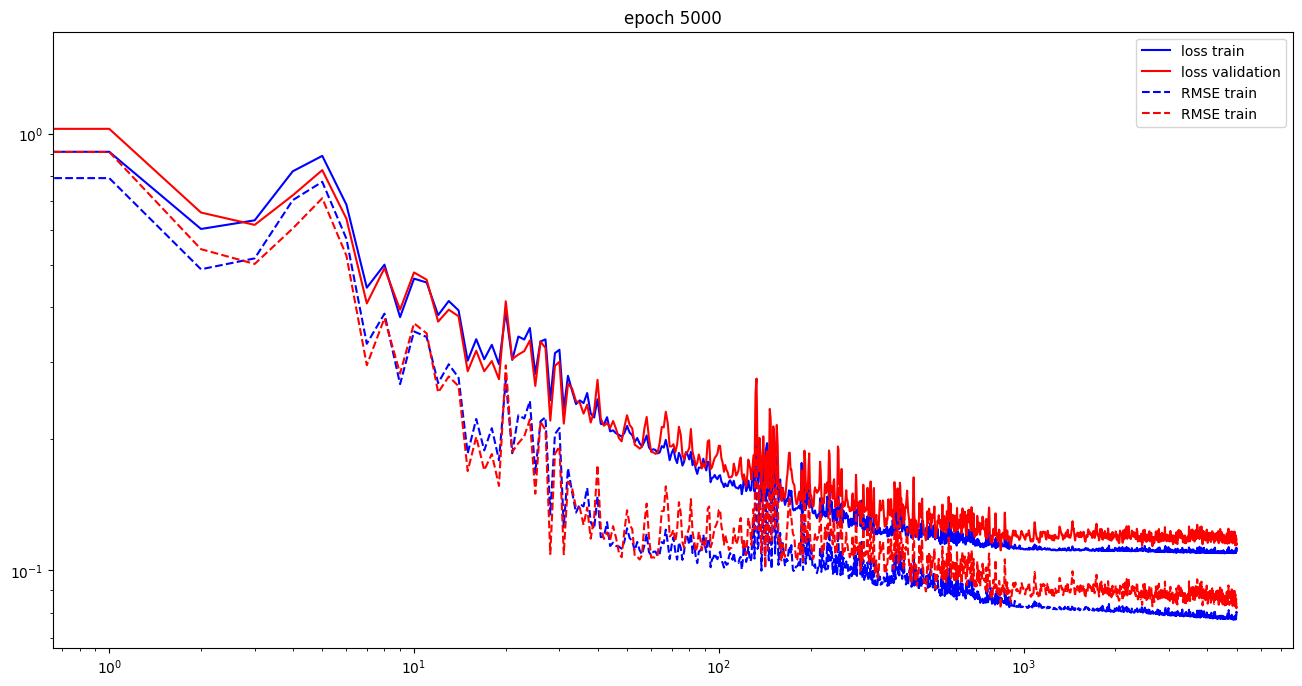

loss (train): 1.122e-01
loss (validation): 1.149e-01
MSE (train): 7.995e-02
MSE (validation): 8.269e-02


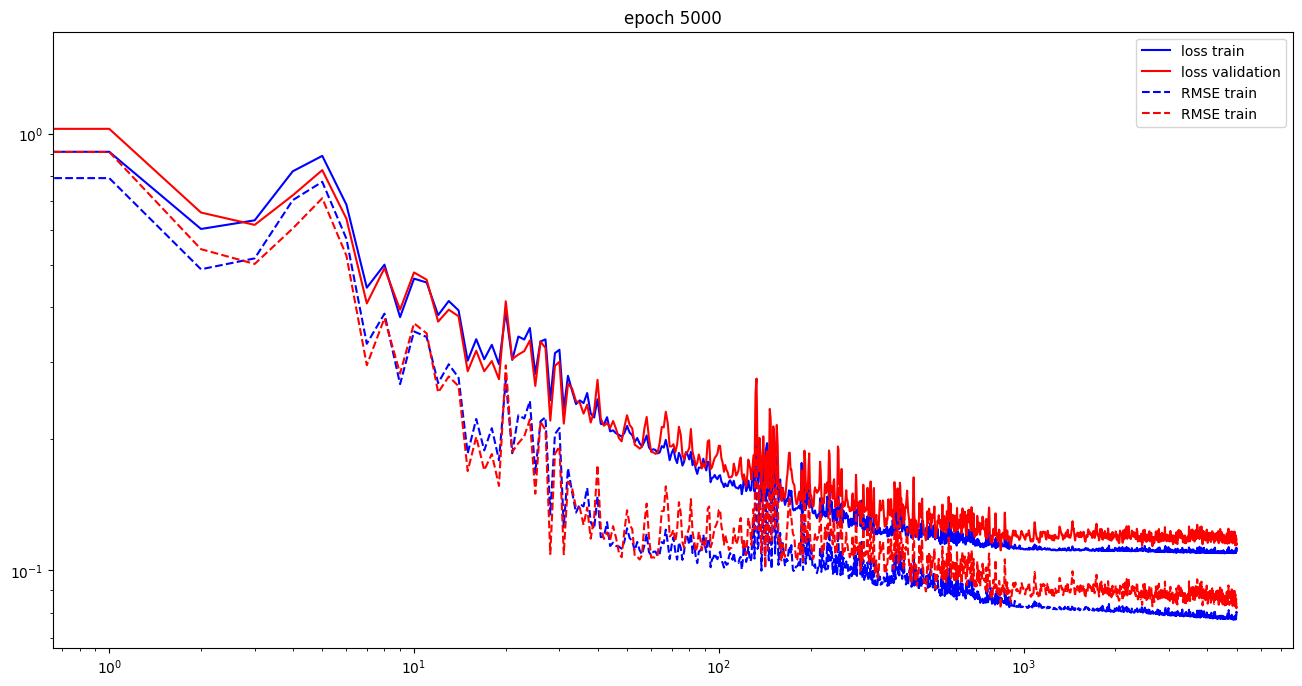

In [54]:
# Hyperparameters
layers_size = [7, 20, 20, 1]
penalization = 2.0
# Training options
num_epochs = 5000
learning_rate_max = 1e-1
learning_rate_min = 5e-3
learning_rate_decay = 1000
batch_size = 100
alpha = 0.9
############################################

params = initialize_params(layers_size)

grad = jax.grad(loss, argnums=2)
MSE_jit = jax.jit(MSE)
loss_jit = jax.jit(loss)
grad_jit = jax.jit(grad)

n_samples = x_train.shape[0]

history_loss_train = list()
history_loss_valid = list()
history_MSE_train = list()
history_MSE_valid = list()

def dump():
    history_loss_train.append(loss_jit(x_train, y_train, params, penalization))
    history_loss_valid.append(loss_jit(x_valid, y_valid, params, penalization))
    history_MSE_train.append(MSE_jit(x_train, y_train, params))
    history_MSE_valid.append(MSE_jit(x_valid, y_valid, params))

dump()
cb = Callback(refresh_rate=250)

velocity = [0.0 for _ in range(len(params))]
for epoch in range(num_epochs):
    learning_rate = max(
        learning_rate_min, learning_rate_max * (1 - epoch / learning_rate_decay)
    )
    idxs = np.random.choice(n_samples, batch_size)
    grads = grad_jit(x_train[idxs, :], y_train[idxs, :], params, penalization)

    for i in range(len(params)):
        velocity[i] = alpha * velocity[i] - learning_rate * grads[i]
        params[i] += velocity[i]

    dump()
    cb(epoch)
cb.draw()

print("loss (train): %1.3e" % history_loss_train[-1])
print("loss (validation): %1.3e" % history_loss_valid[-1])
print("MSE (train): %1.3e" % history_MSE_train[-1])
print("MSE (validation): %1.3e" % history_MSE_valid[-1])

We now want to investigate more in depth the effect of the penalization parameter $\beta$. Wtite a function that, given the penalization parameter, trains the ANN (with the same setting used above) and returns a dictionary containing the final values of:
- train MSE
- validation MSE
- MSW

In [55]:
# Hyperparameters
layers_size = [7, 20, 20, 1]
# Training options
num_epochs = 5000
learning_rate_max = 1e-1
learning_rate_min = 5e-3
learning_rate_decay = 1000
batch_size = 100
alpha = 0.9

def train(penalization):
    params = initialize_params(layers_size)

    grad = jax.grad(loss, argnums=2)
    MSE_jit = jax.jit(MSE)
    loss_jit = jax.jit(loss)
    grad_jit = jax.jit(grad)

    n_samples = x_train.shape[0]

    velocity = [0.0 for _ in range(len(params))]
    for epoch in range(num_epochs):
        learning_rate = max(
            learning_rate_min, learning_rate_max * (1 - epoch / learning_rate_decay)
        )
        idxs = np.random.choice(n_samples, batch_size)
        grads = grad_jit(x_train[idxs, :], y_train[idxs, :], params, penalization)

        for i in range(len(params)):
            velocity[i] = alpha * velocity[i] - learning_rate * grads[i]
            params[i] += velocity[i]
        
    return {
        "MSE_train": MSE(x_train, y_train, params),
        "MSE_valid": MSE(x_valid, y_valid, params),
        "MSW": MSW(params),
    }

Using the above defined function, store the obtained results for $\beta$ = 0, 0.25, 0.5, 0.75, ..., 2.

In [56]:
results = {
    "MSE_train": list(),
    "MSE_valid": list(),
    "MSW": list(),
}

pen_values = np.arange(0, 2.1, 0.5)

for beta in pen_values:
    print("Training for beta=", beta)
    res = train(beta)
    results["MSE_train"].append(res["MSE_train"])
    results["MSE_valid"].append(res["MSE_valid"])
    results["MSW"].append(res["MSW"])

Training for beta= 0.0
Training for beta= 0.5
Training for beta= 1.0
Training for beta= 1.5
Training for beta= 2.0


Plot the trend of the five quantities as functions of $\beta$.

Text(0.5, 1.0, 'MSW')

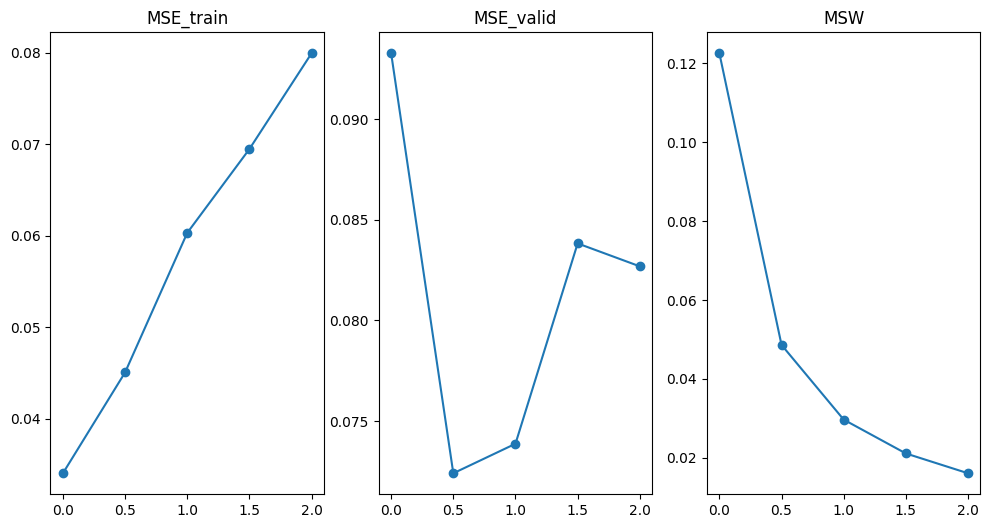

In [57]:
_, axs = plt.subplots(1, 3, figsize=(12, 6))

axs[0].plot(pen_values, results["MSE_train"], "o-")
axs[1].plot(pen_values, results["MSE_valid"], "o-")
axs[2].plot(pen_values, results["MSW"], "o-")

axs[0].set_title("MSE_train")
axs[1].set_title("MSE_valid")
axs[2].set_title("MSW")